# Chaper 6 Stationary Gaussian Process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy

In [ ]:
fft=np.fft.fft
def get_coeffs(u,a,b):
    J = u.size - 1
    assert (J % 2 == 0)
    h = (b - a) / J 
    u1 = np.hstack(((u[0] + u[-1]) / 2, u[1:-1]))
    Uk = (h / (b - a)) * np.exp((-2 * pi * 1j * a / (b - a)) * np.arange(J)) * fft(u1)
    nu = (2*pi/(b - a)) * np.hstack((np.arange(-J/2 + 1, 0), np.arange(1 + J/2)))
    return Uk, nu

def spectral_density(X,T):
    Uk,nu=get_coeffs(X, 0, T)
    f=(np.abs(Uk) ** 2) * T / (2 * pi)
    return f, nu 
def icspde_dst1(u):
    return scipy.fftpack.dst(u,type=1,axis=0)/2


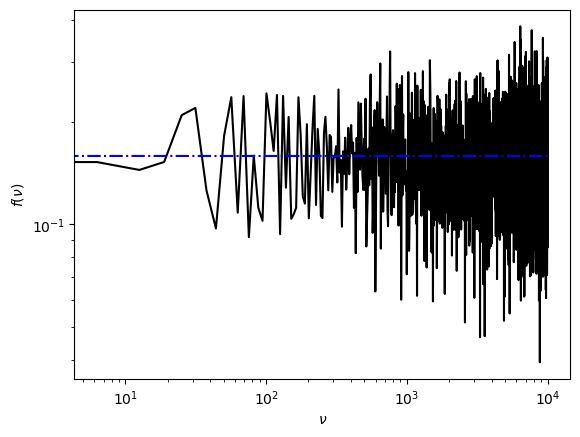

In [5]:
nsamples = 10
J = 3200
T = 10.0
dt = T/J
fc = np.zeros(J+2)
for m in range(nsamples):
    # generate white noise?
    xi=np.random.randn(J+1)
    coeffs=sqrt(2)*xi
    y2=np.hstack([0,icspde_dst1(coeffs),0])
    f,nu=spectral_density(y2,1)
    fc=fc+f
fc = fc/nsamples
poly =0*fc + 1./(2*pi)
plt.loglog(nu, fc, 'k-')
plt.loglog(nu, poly,'b-.')
s=plt.xlabel(r'$\nu$')
s=plt.ylabel(r'$f(\nu)$')

Whittle-Matern covariance 
$$c_q(t)=\frac{|t|^q}{2^{q-1}\Gamma(q)}K_q(|t|)$$


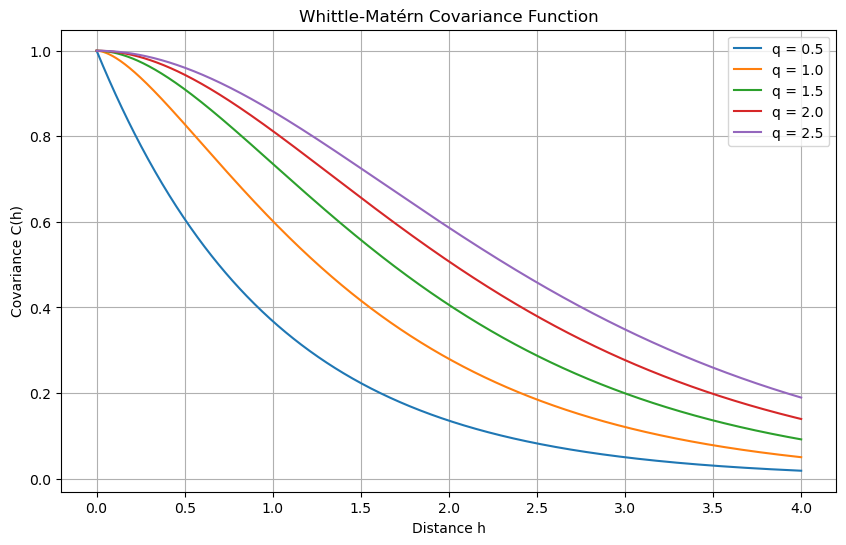

In [2]:
from scipy.special import kv  # kv 是贝塞尔函数 Kν

def whittle_matern_cov(h, q=0.5):
    factor = (2 ** (1 - q)) / gamma(q)
    h = np.asarray(h)
    result = np.ones_like(h)
    non_zero_mask = h != 0
    result[non_zero_mask] = factor * (h[non_zero_mask] ** q) * kv(q, h[non_zero_mask])
    return result
h = np.linspace(0, 4, 1000)
# 绘制不同参数下的 Whittle-Matérn 协方差
plt.figure(figsize=(10, 6))
for q in [0.5, 1.0, 1.5, 2.0, 2.5]:  # 平滑参数
    cov_values = whittle_matern_cov(h, q)
    plt.plot(h, cov_values, label=f"q = {q}")

plt.title("Whittle-Matérn Covariance Function")
plt.xlabel("Distance h")
plt.ylabel("Covariance C(h)")
plt.legend()
plt.grid(True)
plt.show()


The lager q, the smoother the X(t). And we have the condition for mean-square differentiability.
Here we use DKL.

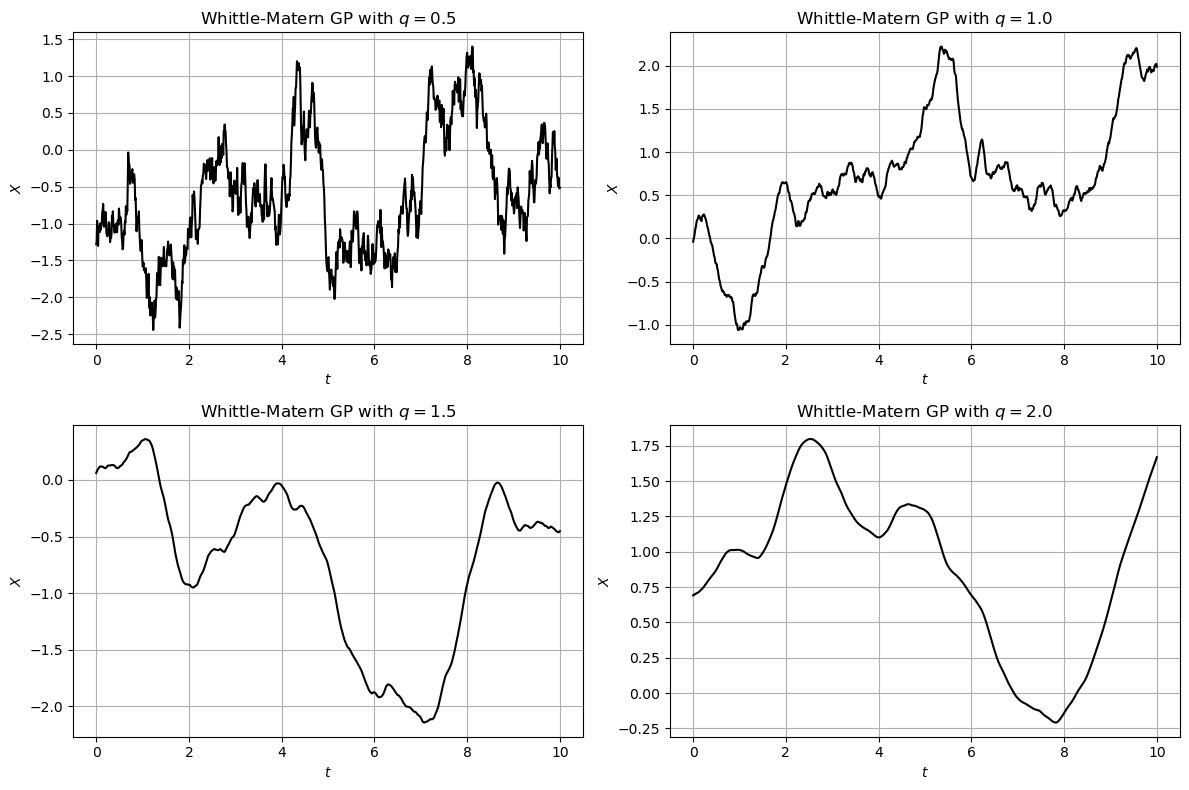

In [6]:
def Whittle_Matern_GP(t, q):
    N = t.size
    C = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            ti = t[i]; tj = t[j]
            h = abs(ti - tj)
            C[i, j] = whittle_matern_cov(h, q)
    S, U = np.linalg.eig(C)
    np.random.seed(24)
    xi = np.random.randn(N) 
    X = np.dot(U, S**0.5 * xi)
    return X  

T = 10; N = 1000
t = np.linspace(0, T, N+1)
q = [0.5, 1.0, 1.5, 2.0]
X = []

# 计算 Whittle_Matern_GP 对应不同 q 的结果
for i in range(len(q)):
    X.append(Whittle_Matern_GP(t, q[i]))
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 子图布局，总大小为 12x8 英寸

for i, ax in enumerate(axes.flat):
    ax.plot(t, X[i], 'k-')  # 画图，黑色线条
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$X$')
    ax.set_title(fr'Whittle-Matern GP with $q = {q[i]}$')
    ax.grid(True)

plt.tight_layout()
plt.show()

The complex Gaussian Process can be used to generate independent sample paths of Gaussian Process.

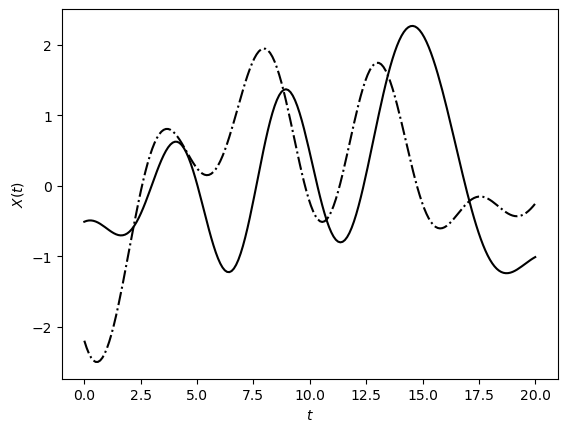

In [7]:
def quad_sinc(t, J, l):
    R = pi / l
    step = 2 * R / J
    Z = np.exp(-1j * t * R)*np.dot(np.random.randn(2), [1,1j]) / sqrt(2)
    for i in range(1, J):
        Z += np.exp(1j * t * (- R + i * step)) * np.dot(np.random.randn(2),[1,1j])
    Z += np.exp(1j * t * R) * np.dot(np.random.randn(2) , [1,1j]) / sqrt(2)
    Z = Z * sqrt(l/(2*pi)) * sqrt(step)
    return Z

t = np.linspace(0, 20, 200)
Z = quad_sinc(t, 100, 2)
plt.plot(t,np.real(Z), 'k-')
plt.plot(t,np.imag(Z), 'k-.')
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$X(t)$')
s=plt.title(r'')

Circulant Embedding

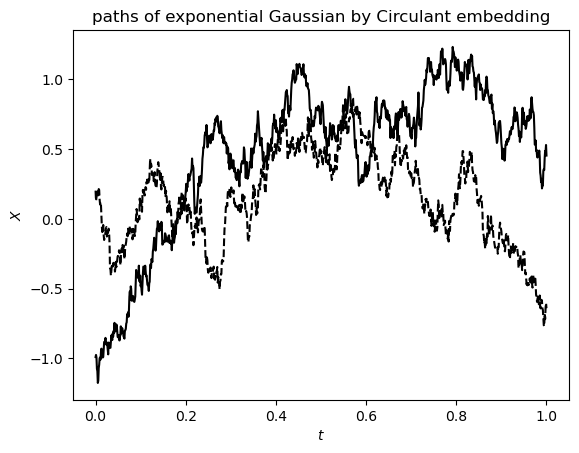

In [17]:
def Circulant_Sample(c):
    N = c.size
    d = np.fft.ifft(c) * N
    xi = np.dot(np.random.randn(N, 2), [1, 1j])
    Z = np.fft.fft(d**0.5 * xi) / sqrt(N)
    X = np.real(Z)
    Y = np.imag(Z)
    return X, Y


def Circulant_Embed_Sample(c):
    N = c.size
    c_tilde = np.hstack([c, c[-2:0:-1]])
    X, Y = Circulant_Sample(c_tilde)
    X = X[0:N]
    Y = Y[0:N]
    return X, Y

def Circlulant_Exponential(t, l):
    ''' 
    t must be positioned uniformly
    '''
    c = np.exp(- np.abs(t) / l)
    X, Y = Circulant_Embed_Sample(c)
    return X, Y

N = 1000
T = 1
l = 1
t = np.linspace(0, T, N + 1)
X,Y = Circlulant_Exponential(t, l)
plt.plot(t,X, 'k-')
plt.plot(t,Y, 'k--')
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$X$')
s=plt.title(r'paths of exponential Gaussian by Circulant embedding')

Sometimes the corvariance function is not non-negative, so, even thought we can increase the size of embedding to avoid the negative eigenvalues, in many cases, we cannot make the circulant embedding non-negative definite. The amount of work increases a lot. We tend to turn to approximation.

In [54]:
def Circulant_Embed_Approx(c):
    c_tilde = np.hstack([c, c[-2:0:-1]])
    N_tilde = c_tilde.size
    d = np.real(np.fft.ifft(c_tilde)) * N_tilde
    d_minus = np.maximum(-d, 0)
    d_pos = np.maximum(d, 0)
    if (np.max(d_minus) > 0):
        print(f'rho(D_minus) = {np.max(d_minus):.4e}')
    xi=np.dot(np.random.randn(N_tilde, 2), [1, 1j])
    Z = np.fft.fft(d_pos**0.5 * xi) / sqrt(N_tilde)
    N = c.size
    X=np.real(Z[0:N]);    Y=np.imag(Z[0:N])
    return X, Y

def Circulant_WM(N, M, dt, q):
    Ndash = N + M - 1
    T=(Ndash+1)*dt
    t=np.linspace(0,T,Ndash+1)
    c = whittle_matern_cov(t, q)
    X, Y = Circulant_Embed_Approx(c)
    X=X[0:N];    Y=Y[0:N];    t=t[0:N]
    return t, X, Y, c

def rho_D_minus(c):
    c_tilde = np.hstack([c, c[-2:0:-1]])
    N_tilde = c_tilde.size
    d = np.real(np.fft.ifft(c_tilde)) * N_tilde
    d_minus = np.maximum(-d, 0)
    return np.max(d_minus)

def rho_WM(N, dt, q):
    M = np.linspace(100, 10000, 100)
    rho = np.zeros(M.size)
    for i, m in enumerate(M):
        m = int(m)
        Ndash = N + m - 1
        T=(Ndash+1)*dt
        t=np.linspace(0,T,Ndash+1)
        c = rho_D_minus(whittle_matern_cov(t, q))
        rho[i] = c
    return  N+M, rho


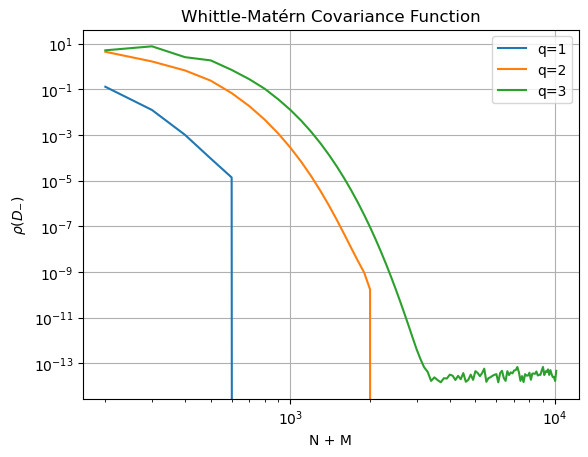

In [58]:
N=100; M=9900
T = 1
dt = 1/(N - 1)
for q in [1, 2, 3]:
    NM, rho = rho_WM(N, dt, q)
    plt.loglog(NM, rho, label=f'q={q}')
plt.title("Whittle-Matérn Covariance Function")
plt.xlabel("N + M")
plt.ylabel(r'$\rho(D_{-})$')
plt.legend()
plt.grid(True)
plt.show()

rho(D_minus) = 8.8731e-04


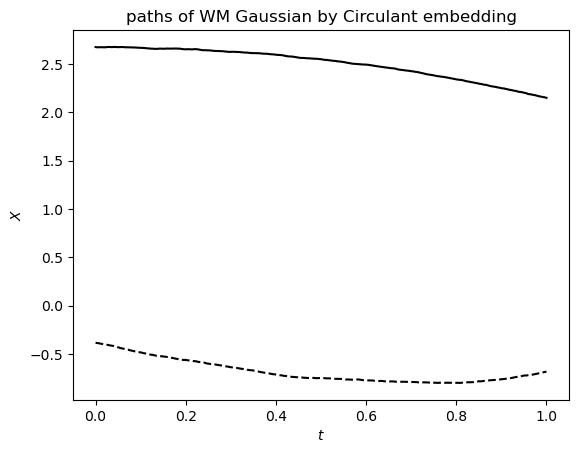

In [59]:
N=1000; M=9900
T = 1
dt = 1/(N - 1)
t, X, Y, c = Circulant_WM(N, M, dt, 2)
plt.plot(t,X, 'k-')
plt.plot(t,Y, 'k--')
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$X$')
s=plt.title(r'paths of WM Gaussian by Circulant embedding')